# What is inside a "yield input package" (YIP)?
A yield input package encodes a coronagraph's response in three different scenarios:
1. A point source not in the center of the image, called an "off-axis PSF". The most obvious example is a planet.
2. A central source for different angular diameters, these are called "stellar intensity maps". This represents the coronagraph's response to a star.
3. An extended source. This is most commonly used for local zodiacal light, or the dust in the solar system the telescope has to point through.

## YIP files
The necessary files for a yield input package are shown below with their default names.

In [1]:
from pathlib import Path

# Path to the yield input package directory
yip_path = Path("../../input/LUVOIR-B-VC6_timeseries")

# Printing out each file in YIP
for item in sorted(yip_path.iterdir()):
    print(item.name)

offax_psf.fits
offax_psf_offset_list.fits
sky_trans.fits
stellar_intens.fits
stellar_intens_diam_list.fits


## YIP file descriptions
### Off-axis PSF files
The `offax_psf.fits` and `offax_psf_offset_list.fits` files describe the PSFs produced by a planet at $(x, y)$ values.
#### `offax_psf.fits`
3d array of PSF maps as a function of $(x, y, k)$. In $(x, y)$ we have standard 2d images that show the PSF. The value at a pixel is the count rate in that pixel divided by the total count rate of the image. The offset $k$ (an integer corresponding to an (x, y) value in the `offax_psf_offset_list.fits` file) represents the astrophysical offset of the source in units of $\lambda / D$. The images are normalized to the total count rate entering the coronagraph.
#### `offax_psf_offset_list.fits`
$2 \times N_k$ array with $(x, y)$ values for each astrophysical offset in the `offax_psf.fits` file, where $N_k$ is the number of offsets $k$. These offsets should adequately sample the space such that the interpolation is valid.

- - -

### Stellar intensity files
The `stellar_intens.fits` and `stellar_intens_diam_list.fits` files describe the coronagraph's response to stars of different diameters in the center of the image.
#### `stellar_intens.fits`
A unitless 3d array of the stellar intensity function $I$, as a function of $(x, y)$ pixel coordinates and the stellar angular diameter $\theta_\textrm{star}$. Values in the map are equal to the stellar count rate in a given pixel divided by the total stellar count rate entering the coronagraph. This does not include reductions such as $QE$, which means that without the coronagraph the sum of I would be unity.
#### `stellar_intens_diam_list.fits`
A list of stellar diameter values $\lambda / D$ corresponding to the $\theta_\textrm{star}$ values in stellar_intens.

- - -

### Sky transmission map
#### `sky_trans.fits`
A unitless 2d array, $T_\textrm{sky}(x,y)$, of the mathematical coronagraphic throughput of an infinitely extended source such as dust in our solar system.

## Off-axis PSFs
### Manually loading and interpreting the files

In [2]:
# Loading the offax_psf files directly
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
from lod_unit import lod # NOTE: `lod` is an astropy unit for lambda/D, I defined it enough that I made it a package

offax_psf_data = pyfits.getdata(Path(yip_path, "offax_psf.fits"))
offax_psf_offsets_list = pyfits.getdata(Path(yip_path, "offax_psf_offset_list.fits"))

To understand how to interpret the provided `offax_psf.fits` data, we first need to know what format the $(x,y)$ offsets are by looking at the data from `offax_psf_offset_list.fits`.

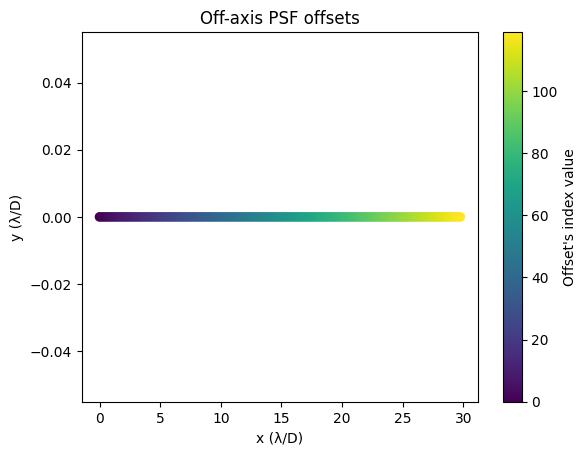

In [3]:
scatter = plt.scatter(offax_psf_offsets_list[:, 0], offax_psf_offsets_list[:, 1], c=np.arange(len(offax_psf_offsets_list)))
plt.title("Off-axis PSF offsets")
plt.xlabel(f"x ({lod})")
plt.ylabel(f"y ({lod})")
plt.colorbar(scatter, label="Offset's index value")
plt.show()

The output above shows that this coronagraph's off-axis PSFs were only provided in the $x$ direction because all the $y$ values in the offset list are 0. Therefore we should see all the PSFs moving in the x direction, which we plot below.

In [4]:
# Utility functions
def set_up_plot():
    rows, cols = 3, 4
    base_size = 3
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(base_size*cols, base_size*rows))
    return fig, axes
def ax_labels_and_ticks(ax):
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("y (pixel)")
    else:
        ax.set_yticks([])
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("x (pixel)")
    else:
        ax.set_xticks([])
    return ax

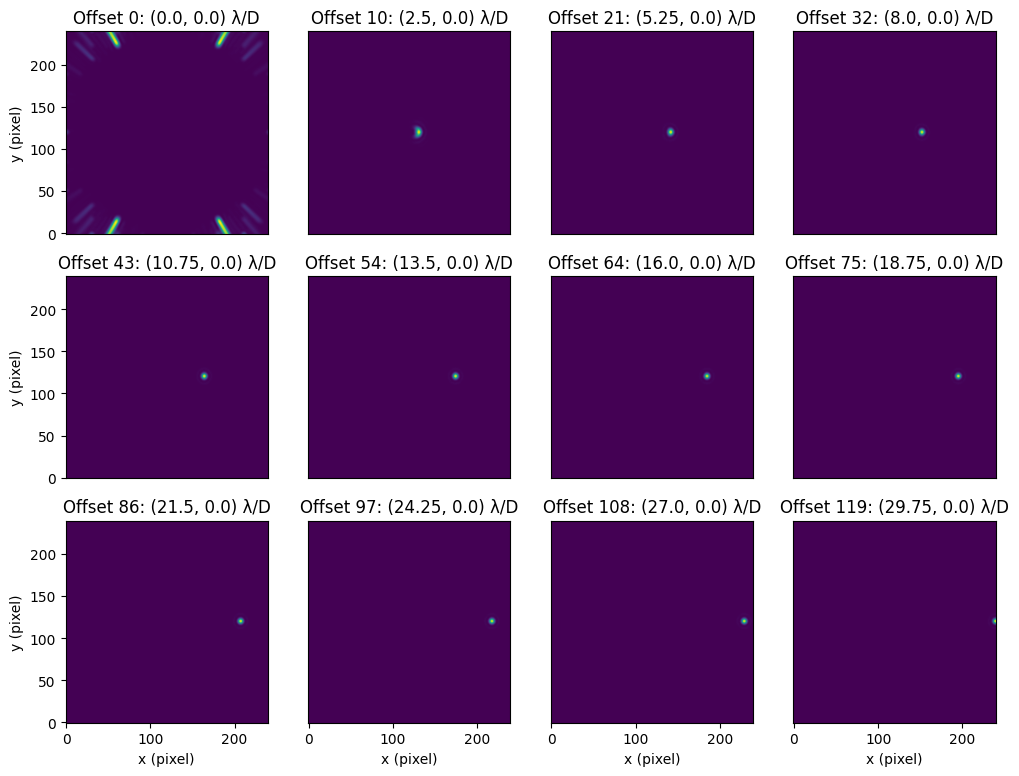

In [5]:
### Plotting PSF data
fig, axes = set_up_plot()

# Choosing the PSF offset index values
offsets = np.linspace(0, len(offax_psf_offsets_list)-1, axes.shape[0]*axes.shape[1], dtype=int)

# Loop through and plot the PSFs
for ax, offset in zip(axes.flatten(), offsets):
    # Get the x, y values of the offset from the offset list
    offset_x, offset_y = offax_psf_offsets_list[offset]
    
    # Plot the PSF data at the current offset
    ax.imshow(offax_psf_data[offset], origin='lower')
    
    # Make the plot pretty
    ax.set_title(f"Offset {offset}: ({offset_x}, {offset_y}) {lod}")
    ax = ax_labels_and_ticks(ax)
plt.show()

Because the PSFs are only in 1 dimension, this YIP is assumed to be radially symmetric.

### Using yippy
Let's recreate that plot using `yippy` without interacting with FITS files directly.

In [12]:
from yippy import Coronagraph

# yippy has a lot of logging messages, disabling to keep this documentation clean
import logging
yippy_logger = logging.getLogger("yippy")
yippy_logger.setLevel(logging.ERROR)

In [13]:
coro = Coronagraph(yip_path)

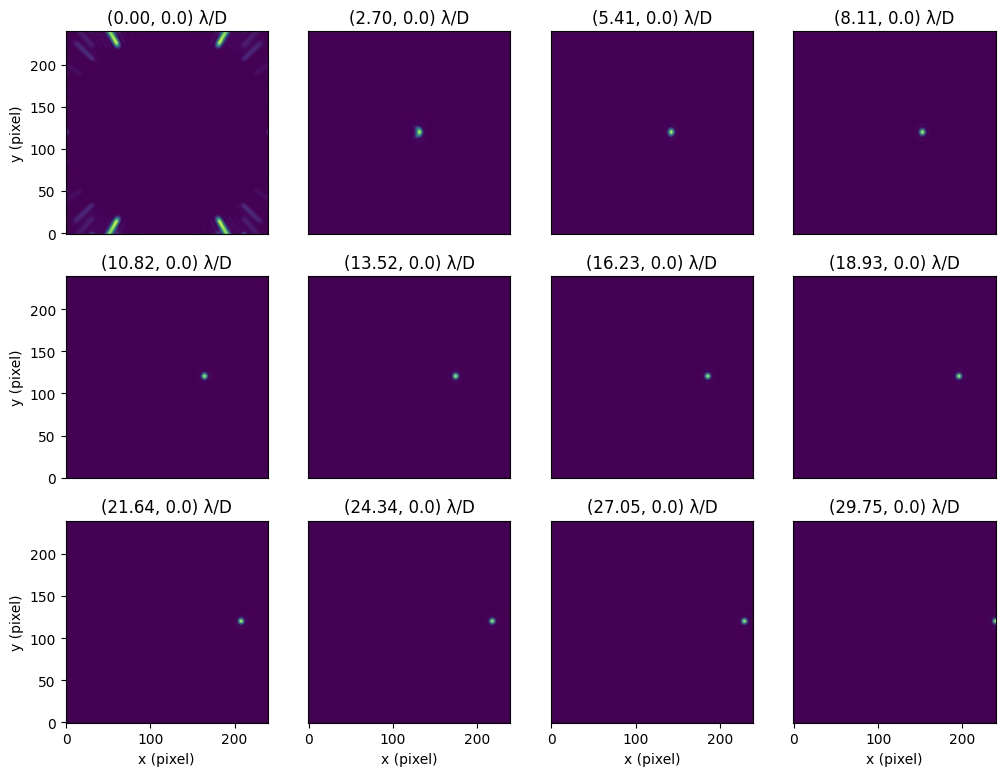

In [8]:
### Plotting PSF data
fig, axes = set_up_plot()

# Choosing the PSF offset index values
x_offsets = np.linspace(0, 29.75, axes.shape[0]*axes.shape[1])*lod

# Loop through and plot the PSFs
for ax, x in zip(axes.flatten(), x_offsets):
    # Plot the PSF data at the current offset
    ax.imshow(coro.offax(x, 0*lod), origin='lower')
    
    # Make the plot pretty
    ax.set_title(f"({x.value:.2f}, {0:.1f}) {lod}")
    ax = ax_labels_and_ticks(ax)
plt.show()

Ok, it isn't an exact match because the offsets in the YIP were not spaced linearly (nor do they have to be for sampling reasons) and I used `np.linspace`. However, this shows that `yippy` interpolates between the provided offsets PSFs.